In [1]:
import torch
import torchvision
from torch import optim
import torchvision.transforms as transforms
import numpy as np
from models import SCrossEntropyLoss, SMLP3, SMLP4, SLeNet, FakeSCrossEntropyLoss
from modules import SModule
from tqdm import tqdm
import time
import argparse
import os
import numpy as np

def mask_por():
    total = 0
    out = 0
    for m in model.modules():
        if isinstance(m, SModule):
            total += torch.prod(torch.Tensor(list(m.mask.shape))).item()
            out += (m.mask == 0).sum()
    return out / total

def eval():
    total = 0
    correct = 0
    model.clear_noise()
    model.clear_mask()
    with torch.no_grad():
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            # images = images.view(-1, 784)
            outputs = model(images)
            predictions = outputs.argmax(dim=1)
            correction = predictions == labels
            correct += correction.sum()
            total += len(correction)
    return (correct/total).item()

def Seval():
    total = 0
    correct = 0
    with torch.no_grad():
        model.clear_noise()
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            # images = images.view(-1, 784)
            outputs = model(images)
            predictions = outputs[0].argmax(dim=1)
            correction = predictions == labels
            correct += correction.sum()
            total += len(correction)
    return (correct/total).item()

def Seval_noise(var):
    total = 0
    correct = 0
    model.clear_noise()

    with torch.no_grad():
        model.set_noise(var)
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            # images = images.view(-1, 784)
            outputs = model(images)
            predictions = outputs[0].argmax(dim=1)
            correction = predictions == labels
            correct += correction.sum()
            total += len(correction)
    return (correct/total).item()

def STrain(epochs, header, verbose=False):
    best_acc = 0.0
    for i in range(epochs):
        running_loss = 0.
        running_l = 0.
        for images, labels in trainloader:
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            # images = images.view(-1, 784)
            outputs, outputsS = model(images)
            loss = criteria(outputs, outputsS,labels)
            loss.backward()
            l = loss + model.fetch_S_grad()
            optimizer.step()
            running_loss += loss.item()
            running_l += l.item()
        test_acc = Seval()
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), f"tmp_best_{header}.pt")
        if verbose:
            print(f"epoch: {i:-3d}, test acc: {test_acc:.4f}, loss: {running_loss / len(trainloader):.4f}, s: {(running_l - running_loss) / len(trainloader):-5.4f}")
        scheduler.step()

def GetSecond():
    model.clear_noise()
    optimizer.zero_grad()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        # images = images.view(-1, 784)
        outputs, outputsS = model(images)
        loss = criteria(outputs, outputsS,labels)
        loss.backward()

def str2bool(a):
    if a == "True":
        return True
    elif a == "False":
        return False
    else:
        raise NotImplementedError(f"{a}")

In [2]:
header = time.time()
header_timer = header
parent_path = "./"
train_epoch = 20
verbose = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BS = 128

trainset = torchvision.datasets.MNIST(root='~/Private/data', train=True,
                                        download=False, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BS,
                                        shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='~/Private/data', train=False,
                                    download=False, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BS,
                                            shuffle=False, num_workers=2)
model = SLeNet()

model.to(device)
model.push_S_device()
model.clear_noise()
model.clear_mask()
criteria = SCrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [20])
pretrained = True
if not pretrained:
    STrain(train_epoch, header, verbose)
    
    state_dict = torch.load(f"tmp_best_{header}.pt")
    model.load_state_dict(state_dict)
    torch.save(model.state_dict(), f"saved_B_{header}.pt")

    no_mask_acc_list = []
    state_dict = torch.load(f"saved_B_{header}.pt")
    print(f"No mask no noise: {Seval():.4f}")
    model.load_state_dict(state_dict)
    model.clear_mask()
    loader = range(10)
    for _ in loader:
        acc = Seval_noise(0.2)
        no_mask_acc_list.append(acc)
    print(f"No mask noise average acc: {np.mean(no_mask_acc_list):.4f}, std: {np.std(no_mask_acc_list):.4f}")
    torch.save(no_mask_acc_list, f"no_mask_list_{header}.pt")

else:
    parent_path = "./pretrained"
    header = 6
    no_mask_acc_list = torch.load(os.path.join(parent_path, f"no_mask_list_{header}.pt"))
    print(f"No mask noise average acc: {np.mean(no_mask_acc_list):.4f}, std: {np.std(no_mask_acc_list):.4f}")
    model.back_real(device)
    model.push_S_device()

state_dict = torch.load(os.path.join(parent_path, f"saved_B_{header}.pt"), map_location=device)
model.load_state_dict(state_dict)
model.back_real(device)
model.push_S_device()
criteria = SCrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [20])
model.clear_noise()
GetSecond()
print(f"S grad before masking: {model.fetch_S_grad().item():E}")

No mask noise average acc: 0.9404, std: 0.0330
S grad before masking: 7.299565E+02


In [3]:
p_list = np.arange(0, 1, 0.01)
model.clear_mask()
print(f"no mask no noise: {Seval():.4f}")

no mask no noise: 0.9920


In [4]:
sail_th_acc_list = []
for i in p_list:
# for i in [0.8]:
    model.clear_mask()
    mask_p = i
    th = model.calc_sail_th(1 - mask_p)
    model.set_mask_sail(th, mode="th")
    for m in model.modules():
        if isinstance(m, SModule):
            m.mask = 1 - m.mask
    acc = Seval()
    sail_th_acc_list.append(acc)

In [5]:
sail_pt_acc_list = []
for i in p_list:
    model.clear_mask()
    mask_p = i
    model.set_mask_sail(1-i, mode="portion")
    for m in model.modules():
        if isinstance(m, SModule):
            m.mask = 1 - m.mask
    acc = Seval()
    sail_pt_acc_list.append(acc)

In [6]:
s_th_acc_list = []
for i in p_list:
    model.clear_mask()
    mask_p = i
    th = model.calc_S_grad_th(1 - mask_p)
    model.set_mask(th, mode="th")
    for m in model.modules():
        if isinstance(m, SModule):
            m.mask = 1 - m.mask
    acc = Seval()
    s_th_acc_list.append(acc)
# print(s_th_acc_list)

In [7]:
s_pt_acc_list = []
for i in p_list:
    model.clear_mask()
    mask_p = i
    th = model.calc_S_grad_th(1 - mask_p)
    model.set_mask(1-i, mode="portion")
    for m in model.modules():
        if isinstance(m, SModule):
            m.mask = 1 - m.mask
    acc = Seval()
    s_pt_acc_list.append(acc)
# print(s_pt_acc_list)

In [8]:
m_pt_acc_list = []
for i in p_list:
    model.clear_mask()
    mask_p = i
    th = model.calc_S_grad_th(1 - mask_p)
    model.set_mask_mag(1-i, mode="portion")
    for m in model.modules():
        if isinstance(m, SModule):
            m.mask = 1 - m.mask
    acc = Seval()
    m_pt_acc_list.append(acc)
# print(m_pt_acc_list)

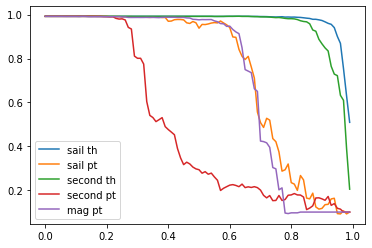

In [13]:
from matplotlib import pyplot as plt
plt.plot(p_list, sail_th_acc_list)
plt.plot(p_list, sail_pt_acc_list)
plt.plot(p_list, s_th_acc_list)
plt.plot(p_list, s_pt_acc_list)
plt.plot(p_list, m_pt_acc_list)
plt.legend(["sail th", "sail pt", "second th", "second pt", "mag pt"])
plt.savefig("obd.svg")

In [1]:
import torch
import numpy as np

In [17]:
sail_th_acc_list, sail_pt_acc_list, s_th_acc_list, s_pt_acc_list, m_pt_acc_list = torch.load("obd.pt")
p_list = np.arange(0, 1, 0.01)

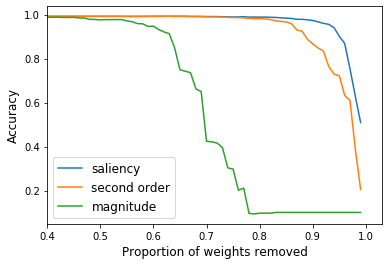

In [21]:
from matplotlib import pyplot as plt
plt.plot(p_list, sail_th_acc_list)
# plt.plot(p_list, sail_pt_acc_list)
plt.plot(p_list, s_th_acc_list)
# plt.plot(p_list, s_pt_acc_list)
plt.plot(p_list, m_pt_acc_list)
plt.legend(["saliency", "second order", "magnitude"], fontsize=12)
plt.xlim(0.4,1.03)
plt.xlabel("Proportion of weights removed", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.savefig("obd.svg")